/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


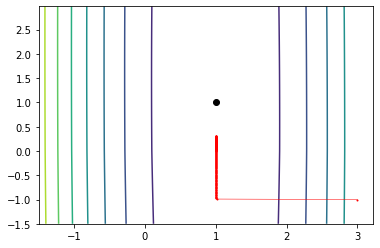

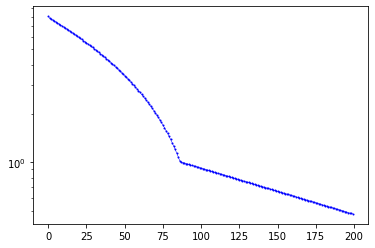

In [52]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Proximal_Gradient_Method:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[300, 0.5],[0.5, 1]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.x_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 2
    
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
    
    def proximal_operation(self, mu, q):
        x_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                x_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    x_projection[i] = 0
                else:
                    x_projection[i] = mu[i] + q
        return x_projection
        
    def main(self):
        # cvx
        w_lasso = cv.Variable((2, 1))
        J = cv.quad_form(w_lasso - self.mu, self.A) + self.lamda * cv.norm(w_lasso, 1)
        objective = cv.Minimize(J)
        constraints = []
        prob = cv.Problem(objective, constraints)
        result = prob.solve(solver = cv.CVXOPT)
        w_lasso = w_lasso.value
        
        plt.contour(self.W1, self.W2, self.Value)
        # 固有値の最大値?
        L = 1.01 * np.max(np.linalg.eig(2 * self.A)[0])
        x_history = []
        fvalues = []
        xt = self.x_init
        
        for t in range(200):
            x_history.append(xt.T)
            #　勾配
            grad = 2 * np.dot(self.A, xt - self.mu)
            xth  = xt - 1 / L * grad
            # Proximal_Operation
            xt   = self.proximal_operation(xth, self.lamda * 1 / L)
            fv   = np.dot(np.dot((xt - self.mu).T, self.A), (xt - self.mu)) + self.lamda * (np.abs(xt[0]) + np.abs(xt[1]))
            fvalues.append(fv)
        # 値の格納
        Value     = np.vstack(fvalues)
        x_history = np.vstack(x_history)
        # Graph描画
        plt.figure(1)
        plt.plot(x_history[:, 0], x_history[:, 1], 'ro-', markersize = 1.0, linewidth = 0.5)
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        
        plt.figure(2)
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), w_lasso - self.mu) + self.lamda * np.sum(np.abs(w_lasso))
        minOfMin  = np.min([minfvalue, np.min(fvalues)])
        plt.semilogy(Value - minOfMin, 'bo-', markersize = 1, linewidth = 0.5)
        
pgm = Proximal_Gradient_Method()
pgm.calc_eval_fun()
pgm.main()

/home/keigo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


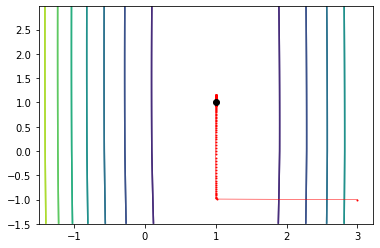

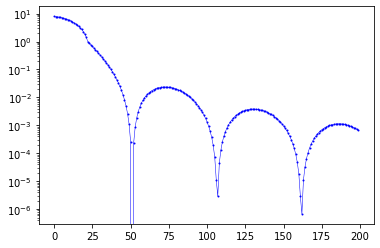

In [63]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools

class Accelerated_Proximal_Gradient_Method:
    def __init__(self):
        self.w_1 = np.arange(-1.5,3,0.01)
        self.w_2 = np.arange(-1.5,3,0.02)
        self.W1, self.W2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        # 評価関数値
        self.Value = np.zeros((len(self.w_1), len(self.w_2)))
        # 重み行列
        self.A = np.array([[300, 0.5],[0.5, 1]])
        # 平均
        self.mu = np.array([[1],[2]])
        # 初期値
        self.x_init = np.array([[3], [-1]])
        # 正則化項係数
        self.lamda = 2
        
    def calc_eval_fun(self):
        # 評価関数値の計算
        for i in range(len(self.w_1)):
            for j in range(len(self.w_2)):
                w = np.vstack([self.w_1[i], self.w_2[j]])
                self.Value[i, j] = np.dot(np.dot((w - self.mu).T, self.A), w - self.mu) + self.lamda * (np.abs(self.w_1[i]) + np.abs(self.w_2[j]))
    
    def proximal_operation(self, mu, q):
        x_projection = np.zeros(mu.shape)
        for i in range(len(mu)):
            if mu[i] > q:
                x_projection[i] = mu[i] - q
            else:
                if np.abs(mu[i]) < q:
                    x_projection[i] = 0
                else:
                    x_projection[i] = mu[i] + q
        return x_projection
    
    def main(self):
        # cvx
        w_lasso = cv.Variable((2, 1))
        J = cv.quad_form(w_lasso - self.mu, self.A) + self.lamda * cv.norm(w_lasso, 1)
        objective = cv.Minimize(J)
        constraints = []
        prob = cv.Problem(objective, constraints)
        result = prob.solve(solver = cv.CVXOPT)
        w_lasso = w_lasso.value
        
        plt.contour(self.W1, self.W2, self.Value)
        # 固有値の最大値?
        L = 1.01 * np.max(np.linalg.eig(2 * self.A)[0])
        x_history  = [self.x_init.T]
        s_history  = [1]
        v_history  = [self.x_init.T]
        fvalues = []
        
        for t in range(200):
            # 速度勾配
            # [-1]は配列の一番最後の要素指定
            vt = v_history[-1].T
            # 勾配
            grad = 2 * np.dot(self.A, vt - self.mu)
            xth  = vt - 1 / L * grad
            xt   = self.proximal_operation(xth, self.lamda * 1 / L)
            fv   = np.dot(np.dot((xt - self.mu).T, self.A), (xt - self.mu)) + self.lamda * (np.abs(xt[0]) + np.abs(xt[1]))
            fvalues.append(fv)
            x_history.append(xt.T)
            
            sprev = s_history[-1]
            st    = (1 + np.sqrt(1 + 4 * sprev ** 2)) / 2.0
            s_history.append(st)
            qt    = (sprev - 1.0) / st
            vnew  = xt + np.dot(qt, (xt - x_history[-2].T))
            v_history.append(vnew.T)
        # 値の格納
        x_history = np.vstack(x_history)
        Value     = np.vstack(fvalues)
        s_history = np.vstack(s_history)
        v_history = np.vstack(v_history)
        # Graph描画
        plt.figure(1)
        plt.contour(self.W1, self.W2, self.Value)
        plt.plot(x_history[:, 0], x_history[:, 1], 'ro-', markersize = 1, linewidth = 0.5);
        plt.plot(w_lasso[0], w_lasso[1], 'ko')
        
        plt.figure(2)
        minfvalue = np.dot(np.dot((w_lasso - self.mu).T, self.A), w_lasso - self.mu) + self.lamda * np.sum(np.abs(w_lasso))
        minOfMin  = np.min([minfvalue, np.min(fvalues)])
        plt.semilogy(Value - minOfMin, 'bo-', markersize = 1, linewidth = 0.5)
        
apgm = Accelerated_Proximal_Gradient_Method()
apgm.calc_eval_fun()
apgm.main()